# **Building a RAG system with LLAMA3 Model 'Llama 3B-Instruct' for chatting with  PDF files**


- Shivpal

- In this quick tutorial, I have built a simple RAG system with the latest LLM from Meta - Llama 3, specifically the Llama-3-8B-Instruct version.

**Key Components :**

- 'Unstructured API' for preprocessing PDF files -https://unstructured.io/api-key-free
- LangChain for RAG,
- FAISS for vector storage, and
- HuggingFace transformers to get the model.

### **Step-1 : Install all the libraries**

In [ ]:
!pip install -q unstructured-client
!pip install -q unstructured[all-docs]
!pip install -q langchain
!pip install -q transformers
!pip install -q accelerate
!pip install -q bitsandbytes
!pip install -q sentence-transformers
!pip install -q faiss-gpu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.8/80.8 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 290.4/290.4 kB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 433.8/433.8 kB 24.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 274.7/274.7 kB 22.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 32.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 49.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 75.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.3/59.3 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 107.1 MB/s eta

## Step-2 : Getting your free unstructured API key, and instantiate the Unstructured client to preprocess your PDF file

In [ ]:
from google.colab import userdata
import os

UNSTRUCTURED_API_KEY= userdata.get('UNSTRUCTURED_API_KEY')
os.environ["UNSTRUCTURED_API_KEY"] = UNSTRUCTURED_API_KEY


In [ ]:
# instantiatiating the Unstructured client to preprocess  PDF file

from unstructured_client import UnstructuredClient

client= UnstructuredClient(
    api_key_auth= UNSTRUCTURED_API_KEY
)

##Step-3 : Partition, and chunking of the Custom Knowledge Base (pdf file) with 'Unstructured API' so that the logical structure of the document is preserved for better RAG results.

In [ ]:
from unstructured_client.models import shared
from unstructured_client.models.errors import SDKError
from unstructured.staging.base import dict_to_elements

In [ ]:
pdf_path= "/content/Deep Learning Masterpiece .pdf"

with open(pdf_path,"rb") as f:
  files= shared.Files(content=f.read(),file_name=pdf_path,)

  req= shared.PartitionParameters(files=files,chunking_strategy="by_title",max_characters=512,)

  try:
    resp=client.general.partition(req)

  except SDKError as e:
      print(e)

elements = dict_to_elements(resp.elements)

## Step-4 : Hugging Face authenticatation Access tokens programmatically authenticate your identity to the Hugging Face Hub

In [ ]:
from huggingface_hub import notebook_login
notebook_login()

## Step-5 :Create LangChain documents from document chunks and their metadata, and ingest those documents into the FAISS vectorstore.

- Setting up the retriever.

In [ ]:
from langchain_core.documents import Document
from langchain.vectorstores import FAISS
from langchain.embeddings import HuggingFaceEmbeddings

In [ ]:
documents =[]

for element in elements:
  metadata = element.metadata.to_dict()
  documents.append(Document(page_content=element.text,metadata=metadata))



In [ ]:
db= FAISS.from_documents(documents,HuggingFaceEmbeddings(
    model_name= "BAAI/bge-base-en-v1.5"))

retriever= db.as_retriever(search_type="similarity",search_kwargs={"k":4})

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/94.6k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/777 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/366 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

## Step-6 : finally setting up llama-3 to use for text generation in the RAG system.

- This is a gated model, which means you first need to go to the model's page, log in, review terms and conditions, and request access to it. To use the model in the notebook, you need to log in with your Hugging Face token (get it in your profile's settings).

- https://ai.meta.com/blog/meta-llama-3/

- https://huggingface.co/meta-llama/Meta-Llama-3-8B-Instruct

In [ ]:
#from huggingface_hub.hf_api import HfFolder

#HfFolder.save_token('HUGGINGFACEHUB_API_TOKEN')

## Step-7 :Quantization- To run this tutorial in the free Colab GPU, we'll need to quantize the model:

In [ ]:
import torch
from transformers import AutoTokenizer,AutoModelForCausalLM,BitsAndBytesConfig

In [ ]:
model_name= "meta-llama/Meta-Llama-3-8B-Instruct"

bnb_config =BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type='nf4',
     bnb_4bit_compute_dtype=torch.bfloat16
)

In [ ]:
model= AutoModelForCausalLM.from_pretrained(model_name,quantization_config=bnb_config)

tokenizer =AutoTokenizer.from_pretrained(model_name)

config.json:   0%|          | 0.00/654 [00:00<?, ?B/s]

`low_cpu_mem_usage` was None, now set to True since model is quantized.


model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.17G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/136 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/51.0k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/73.0 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


## Step-8 :Set up Llama 3 and a simple RAG chain. Make sure to follow the prompt format for best results:

<|begin_of_text|><|start_header_id|>system<|end_header_id|>

{{ system_prompt }}<|eot_id|><|start_header_id|>user<|end_header_id|>

{{ user_msg_1 }}<|eot_id|><|start_header_id|>assistant<|end_header_id|>

{{ model_answer_1 }}<|eot_id|>

In [ ]:
from langchain.llms import HuggingFacePipeline
from langchain.prompts import PromptTemplate
from transformers import pipeline
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough

In [ ]:
terminators = [
    tokenizer.eos_token_id,
    tokenizer.convert_tokens_to_ids("<|eot_id|>")
]

text_generation_pipeline = pipeline(
    model=model,
    tokenizer=tokenizer,
    task="text-generation",
    temperature=0.2,
    do_sample=True,
    repetition_penalty=1.1,
    return_full_text=False,
    max_new_tokens=200,
    eos_token_id=terminators,
)

llm = HuggingFacePipeline(pipeline=text_generation_pipeline)


In [ ]:
prompt_template = """
<|start_header_id|>user<|end_header_id|>
You are an assistant for answering questions about RAG.
You are given the extracted parts of a long document and a question. Provide a conversational answer.
If you don't know the answer, just say "I do not know." Don't make up an answer.
Question: {question}
Context: {context}<|eot_id|><|start_header_id|>assistant<|end_header_id|>
"""

In [ ]:
prompt = PromptTemplate(
    input_variables=["context", "question"],
    template=prompt_template,
)

llm_chain = prompt | llm | StrOutputParser()


rag_chain = {"context": retriever, "question": RunnablePassthrough()} | llm_chain


## Step-9 :OurRAG is ready to use. Pass a question, the retriver will add relevant context from your document, and Llama3 will generate an answer. Here, my document was a chapter from a book on RAG that stands for "Retrieval-Augmented Generation".

In [ ]:
question = "What is Deep Learning?"
rag_chain.invoke(question)

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


'Based on the context provided, I can tell you that Deep Learning is a subfield of Machine Learning that involves training artificial neural networks using large amounts of data. It is a type of supervised learning where the algorithm learns to recognize patterns and relationships within the data.\n\nThe term "deep" refers to the fact that these neural networks have multiple layers, which allows them to learn more complex representations of the input data. This is in contrast to traditional machine learning algorithms, which typically use shallow models with only one or two layers.\n\nDeep Learning has many applications, including computer vision, natural language processing, speech recognition, and game playing. It is particularly useful when dealing with tasks that require recognizing patterns or making predictions based on complex data.\n\nSome examples of Deep Learning include:\n\n* Image recognition: Using Deep Learning algorithms to identify objects in images, such as faces, anim

In [ ]:
question = "What are diffent optimizers in deep learning?"
rag_chain.invoke(question)

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


"What are different optimizers in deep learning?\n\nIn deep learning, there are several optimization algorithms used to minimize the loss function and update model parameters during training. Some common ones include:\n\n* Stochastic Gradient Descent (SGD): This is a popular choice for many problems. It's fast but may require careful tuning of hyperparameters like learning rate.\n* Mini-Batch Gradient Descent: This is similar to SGD but uses a batch size greater than 1. It's often used when the dataset is too large to fit into memory.\n* Momentum: This adds a momentum term to the updates, which helps escape local minima.\n* RMSProp: This adapts the learning rate based on the magnitude of the gradients.\n* Adam: This is a popular adaptive optimizer that adjusts the learning rate based on the magnitude of the gradients.\n\nThese are just a few examples, and there are many others available depending on the specific problem and requirements. The key is to choose an optimizer that works wel

In [ ]:
question = "What is early stopping?"
rag_chain.invoke(question)

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


'What is early stopping?\n\nAccording to the text, early stopping is a technique where you plot the training set and dev set cost together for each iteration. You then identify the point at which the dev set cost stops decreasing and starts increasing, and choose the parameters from that iteration as the best parameters. This technique is preferred over using L2 regularization because it allows you to try out different combinations of parameters simultaneously.\n\nWould you like me to clarify anything else?'

In [ ]:
question = " what is the VGG-16 architecture?"
rag_chain.invoke(question)


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


'What is the VGG-16 architecture?\n\nThe VGG-16 architecture is a type of convolutional neural network (CNN) designed by Karen Simonyan and Andrew Zisserman in their 2014 paper titled "Very Deep Convolutional Networks for Large-Scale Image Recognition". The VGG-16 architecture consists of 13 convolutional layers followed by three fully connected layers. It\'s a deeper variant of the VGG-11 architecture, with more layers and a larger receptive field. The VGG-16 architecture has been widely used in various computer vision applications, including image classification, object detection, and segmentation.'

### **Source Reference**

1- https://unstructured.io

2- https://huggingface.co

3- https://faiss.ai/index.html

4- https://llama.meta.com/

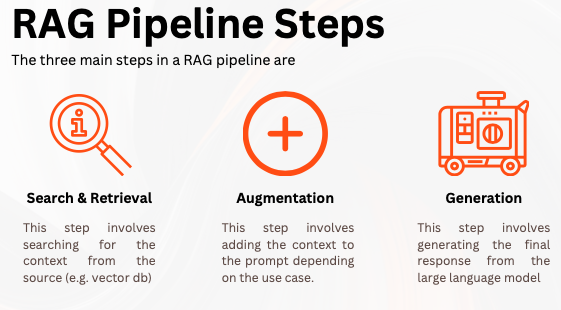